In [208]:
import pymysql
import pymysql.cursors
import sqlite3
import ipywidgets as widgets
from IPython.display import display
import datetime
import numpy as np
import pandas as pd

In [218]:
def get_db_conn_root():
    connection = pymysql.connect(
                    host='127.0.0.1',
                    user='root',
                    password='x3n0n136',
                    db='lab206',
                    port=3308,
                    cursorclass=pymysql.cursors.DictCursor)
    return connection

def get_db_conn_write():
    connection = pymysql.connect(
                    host='127.0.0.1',
                    user='exo_rw',
                    password='x3n0n',
                    db='lab206',
                    port=3308,
                    cursorclass=pymysql.cursors.DictCursor)
    return connection

def get_db_conn_read():
    connection = pymysql.connect(
                    host='127.0.0.1',
                    user='exo_ro',
                    password='xenon',
                    db='lab206',
                    port=3308,
                    cursorclass=pymysql.cursors.DictCursor)
    return connection


def setup_db():
    connection = get_db_conn_root()
    haz_exoro = False
    haz_exorw = False
    haz_table = False
    #Check Users:
    try:
        with connection.cursor() as cursor:
            cursor.execute("SELECT User from mysql.user")
            ret_users = cursor.fetchall()
            cursor.execute("SHOW TABLES LIKE 'testtable'")
            ret_tables = cursor.fetchall()
    finally:
        connection.close()
    for u in ret_users:
        if u['User'] == 'exo_ro':
            print("User exo_ro already exists")
            haz_exoro = True
        elif u['User'] == 'exo_rw':
            print("User exo_rw already exists")
            haz_exorw = True
    if len(ret_tables)>0:
            print("Table testtables already exists")
            haz_table = True
    if False in [haz_exoro, haz_exorw, haz_table]:
        connection = get_db_conn_root()
        try:
            with connection.cursor() as cursor:
                if not haz_exoro:
                    print("Creating exo_ro user")
                    sql = "CREATE USER 'exo_ro'@'%' IDENTIFIED BY 'xenon';"
                    cursor.execute(sql)
                    connection.commit()
                    sql = "GRANT SELECT ON lab206.* to 'exo_ro'@'%';"
                    cursor.execute(sql)
                    connection.commit()
                    cursor.execute("FLUSH PRIVILEGES")
                    connection.commit()
                if not haz_exorw:
                    print("Creating exo_rw user")
                    sql = "CREATE USER 'exo_rw'@'%' IDENTIFIED BY 'x3n0n';"
                    cursor.execute(sql)
                    connection.commit()
                    sql = "GRANT SELECT, INSERT ON lab206.* to 'exo_rw'@'%'"
                    cursor.execute(sql)
                    connection.commit()
                    cursor.execute("FLUSH PRIVILEGES")
                    connection.commit()
                if not haz_table:
                    print("Creating table testtable")
                    sql = """CREATE TABLE testtable (
                             time TIMESTAMP, 
                             v1 DECIMAL(6,4),
                             v2 DECIMAL(6,4),
                             v3 DECIMAL(6,4),
                             v4 DECIMAL(6,4),
                             v5 DECIMAL(6,4)
                             );"""
                    cursor.execute(sql)
                    connection.commit()
        finally:
            connection.close()   
            
def get_db_users():
    connection = get_db_conn_root()
    try:
        with connection.cursor() as cursor:
            sql = "SELECT User, Host, authentication_string FROM mysql.user;"
            cursor.execute(sql)
            users = cursor.fetchall()
    finally:
        connection.close()
    print(users)
    
def db_data_point():
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    #timestamp = time.time()
    randdata = numpy.random.random_sample(5)
    v1 = 25+randdata[0]
    v2 = 25+randdata[1]*5
    v3 = 25+randdata[2]*3
    v4 = 1+randdata[3]*0.25
    v5 = 5+randdata[4]
    connection = get_db_conn_write()
    try:
        with connection.cursor() as cursor:
            values_str = "'%s', '%f', '%f', '%f', '%.4f', '%f'"%(timestamp, v1, v2, v3, v4, v5)
            sql = """INSERT INTO testtable 
                     (time, v1, v2, v3, v4, v5)
                     VALUES (%s);"""%values_str
            #print(sql)
            cursor.execute(sql)
            connection.commit()
    finally:
        connection.close()

def get_data(t0,tf,np=0):
    if type(t0) == datetime.datetime:
        t0 = t0.strftime('%Y-%m-%d %H:%M:%S')
    if type(tf) == datetime.datetime:
        tf = tf.strftime('%Y-%m-%d %H:%M:%S')
    sql = "SELECT * FROM testtable WHERE time > '%s' AND time < '%s'"%(t0,tf)
    connection = get_db_conn_read()
    try:
        with connection.cursor() as cursor:
            cursor.execute(sql)
            data = cursor.fetchall()
    finally:
        connection.close()
    return pd.DataFrame(data)

In [219]:
setup_db()
get_db_users()

User exo_ro already exists
User exo_rw already exists
Table testtables already exists
[{'User': 'exo_ro', 'Host': '%', 'authentication_string': '$A$005$(P+(K(/c{Ar\x0c\\?\x04\x0f\x1c99\x18jxWA2dsZzNDsi0YDcBlJtn9vQhflGr7mrJGpABtYQtC'}, {'User': 'exo_rw', 'Host': '%', 'authentication_string': '$A$005$\x05/qmQ\x01H{\x1b2UE\x1a0[U\x04\x7f\x02}YLFJTrn2HimAPDsKherZGzPFCviPf5LRO17iBR2.b44'}, {'User': 'root', 'Host': '%', 'authentication_string': '$A$005$YeP\x02*\x01\\p>>c2kO\x07\x083Cm*BPZGYdprkffOHDXofWWOpqMgckV28Nt6mEUi10fYcPA'}, {'User': 'mysql.infoschema', 'Host': 'localhost', 'authentication_string': '$A$005$THISISACOMBINATIONOFINVALIDSALTANDPASSWORDTHATMUSTNEVERBRBEUSED'}, {'User': 'mysql.session', 'Host': 'localhost', 'authentication_string': '$A$005$THISISACOMBINATIONOFINVALIDSALTANDPASSWORDTHATMUSTNEVERBRBEUSED'}, {'User': 'mysql.sys', 'Host': 'localhost', 'authentication_string': '$A$005$THISISACOMBINATIONOFINVALIDSALTANDPASSWORDTHATMUSTNEVERBRBEUSED'}, {'User': 'root', 'Host': 'loc

In [230]:
for i in range(20):
    db_data_point()
    time.sleep(2)

C:\Users\bung\Anaconda3\envs\mysqlplotly\lib\site-packages\pymysql\cursors.py:329: Warning:

(1265, "Data truncated for column 'v1' at row 1")

C:\Users\bung\Anaconda3\envs\mysqlplotly\lib\site-packages\pymysql\cursors.py:329: Warning:

(1265, "Data truncated for column 'v2' at row 1")

C:\Users\bung\Anaconda3\envs\mysqlplotly\lib\site-packages\pymysql\cursors.py:329: Warning:

(1265, "Data truncated for column 'v3' at row 1")

C:\Users\bung\Anaconda3\envs\mysqlplotly\lib\site-packages\pymysql\cursors.py:329: Warning:

(1265, "Data truncated for column 'v5' at row 1")



In [221]:
t0 = datetime.datetime.now() - datetime.timedelta(seconds=1000)
tf = datetime.datetime.now()
data = get_data(t0, tf)

In [226]:
data["time"][:]

0   2020-01-19 19:19:30
1   2020-01-19 19:19:33
2   2020-01-19 19:19:34
3   2020-01-19 19:19:36
4   2020-01-19 19:19:38
5   2020-01-19 19:20:04
Name: time, dtype: datetime64[ns]

C:\Users\bung\Anaconda3\envs\mysqlplotly\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



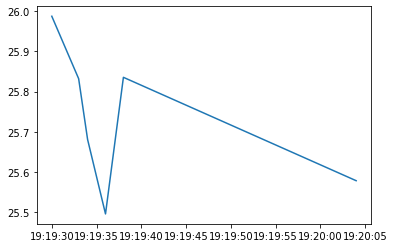

In [227]:
import matplotlib.pyplot as plt
plt.plot(data["time"],data["v1"])

In [229]:
data.to_numpy()[:,0]

array([Timestamp('2020-01-19 19:19:30'), Timestamp('2020-01-19 19:19:33'),
       Timestamp('2020-01-19 19:19:34'), Timestamp('2020-01-19 19:19:36'),
       Timestamp('2020-01-19 19:19:38'), Timestamp('2020-01-19 19:20:04')],
      dtype=object)

{'time': datetime.datetime(2020, 1, 19, 18, 47),
 'v1': Decimal('25.3604'),
 'v2': Decimal('28.4813'),
 'v3': Decimal('27.8774'),
 'v4': Decimal('1.0643'),
 'v5': Decimal('5.8642')}